In [5]:
# IMPORT AND CONVERT TO NUMPY ARRAY - FUNCTION FROM TASGEOEXAMPLE
import rasterio
import numpy as np
import os  
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import generic_filter
import cupy as cp
from scipy.stats import mode
from tkinter import Tk
from tkinter.filedialog import askopenfilenames
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling

In [12]:
#GEOSPATIAL IMPORT
raster_map = r"C:\Users\TyHow\Documents\3. Work\GIS Stuff\SCP testing\output_rasters\calingasta_best_output.tif"

# Read the GeoTIFF
data, names = [], []  # Lists to store data and corresponding file names

with rasterio.open(raster_map, 'r') as src:
    # Read spatial information
    transform = src.transform  # Get affine transformation matrix
    crs = src.crs  # Get the coordinate reference system
    region = (src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3])  # Get bounding box coordinates (left, bottom, right, top)
    
    # Read band 1 data
    d = src.read(1).astype('float32')  # Read data from the first band and convert to float32
    nodata_mask = d == src.nodata  # Create a mask for NoData values
    d[nodata_mask] = np.nan  # Replace NoData values with NaN
    
    # Append data to lists
    data.append(d)  # Append data to the list
    names.append(os.path.basename(raster_map).replace('.tif', ''))  # Append file name to the list (without extension)

# Stack list into 3D numpy array
data = np.stack(data)  # Stack the list of arrays into a 3D numpy array
print(data)
print(data.shape, names)



[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
(1, 5604, 3497) ['calingasta_best_output']


In [13]:
#BATCH GEOSPATIAL IMPORT

import rasterio
import numpy as np
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilenames
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling

# Open a file selection dialog for the user to select multiple raster files
root = Tk()
root.withdraw()  # Hide the root window
root.attributes("-topmost", True)  # Bring the dialog to the front

# Open the file selection dialog
raster_files = askopenfilenames(
    title="Select Raster Files",
    filetypes=[("GeoTIFF files", "*.tif"), ("All files", "*.*")]
)

# Lists to store data and corresponding file names
data = []  
names = []

# Determine the target grid size and transformation
target_transform = None
target_width = None
target_height = None
target_crs = None

# First, determine the common CRS and the bounding box that covers all rasters
for raster_file in raster_files:
    with rasterio.open(raster_file, 'r') as src:
        if target_crs is None:
            target_crs = src.crs  # Use the CRS from the first raster
        if target_transform is None:
            target_transform = src.transform  # Use the transform from the first raster
            target_width = src.width
            target_height = src.height
        else:
            # Adjust the target bounding box to encompass the new raster
            left, bottom, right, top = src.bounds
            existing_bounds = rasterio.transform.array_bounds(target_height, target_width, target_transform)
            new_bounds = (
                min(existing_bounds[0], left), 
                min(existing_bounds[1], bottom), 
                max(existing_bounds[2], right), 
                max(existing_bounds[3], top)
            )
            target_transform, target_width, target_height = rasterio.warp.calculate_default_transform(
                src.crs, target_crs, src.width, src.height, *new_bounds
            )

# Now, reproject and resample each raster to the common grid
for raster_file in raster_files:
    with rasterio.open(raster_file, 'r') as src:
        # Prepare the output array
        data_array = np.full((target_height, target_width), np.nan, dtype=np.float32)
        
        # Handle NoData value
        nodata_value = src.nodata
        if nodata_value is None:
            nodata_value = np.nan  # If NoData is not set, assume NaN
        
        # Reproject the source data to the target grid
        reproject(
            source=rasterio.band(src, 1),
            destination=data_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest,
            src_nodata=nodata_value,  # Specify the source NoData value
            dst_nodata=np.nan  # Use NaN as the destination NoData
        )

        # Append the resampled data and names to lists
        data.append(data_array)  # Append the resampled data array
        names.append(os.path.basename(raster_file).replace('.tif', ''))  # Append file name without extension

# Stack list into a 3D numpy array
data = np.stack(data, axis=0)  # Stack the list of arrays into a 3D numpy array
print(data)
print(data.shape, names)

# Now you have a 3D numpy array (layer, x, y) with all data aligned to the same grid.


[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
(2, 5605, 3498) ['calingasta_best_output', 'calingasta_mag_anom_output_cropped']


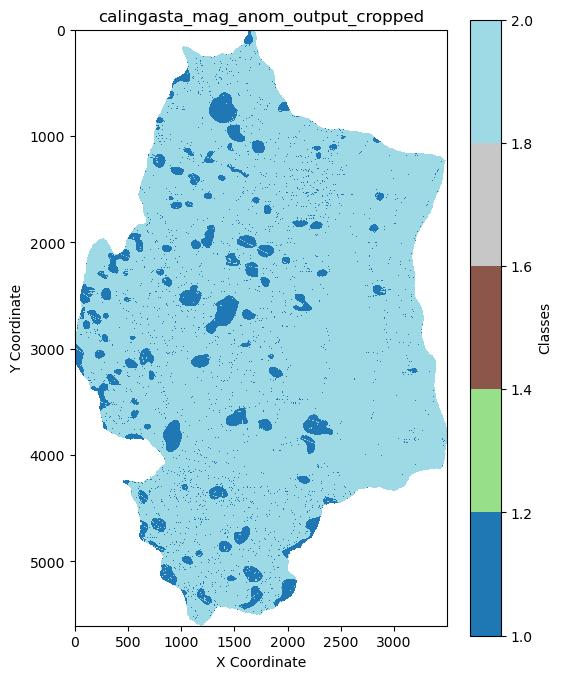

In [18]:
# PLOT
plt.figure(figsize=(6, 8))

# Create a colormap with unique colors for each unique class
cmap = plt.get_cmap('tab20', len(np.unique(data[0][~np.isnan(data[0])])))

layer = 1

# Plot the data
plt.imshow(data[layer], cmap=cmap, interpolation='nearest')
plt.colorbar(label='Classes')  # Show a color bar with class labels
#plt.title('Classified Raster Plot')
plt.title(f'{names[layer]}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [78]:
#HANDLE NANS
# Convert "nan" strings to np.nan
def preprocess_data(input_array):
    # Convert input data to a NumPy array if not already
    input_array = np.array(input_array)
    
    # Check if there are any string "nan" values and replace them with np.nan
    input_array = np.where(input_array == "nan", np.nan, input_array)
    
    # Ensure the data is of a floating-point type to handle NaN values properly
    input_array = input_array.astype(np.float32)
    
    return input_array


# Preprocess data to handle "nan" strings
data_preproc = preprocess_data(data)

print(data_preproc)

print("Data type of the array:", data_preproc.dtype)


num_valid_entries = np.sum(~np.isnan(data_preproc))
print(f"Number of valid entries in the data: {num_valid_entries}")


[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
Data type of the array: float32
Number of valid entries in the data: 12298467


In [79]:
# MEDIAN FILTER (CUDA)

# Define a custom CUDA kernel for the median filter
median_filter_kernel = cp.RawKernel(r'''
extern "C" __global__
void median_filter(const float* input, float* output, int width, int height, int window_size) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    
    int half_window = window_size / 2;
    int window_elements = window_size * window_size;
    float window[1024];  // Assuming max window size of 32x32 for simplicity

    // Ensure the pixel is within bounds
    if (x >= half_window && x < width - half_window && y >= half_window && y < height - half_window) {
        int count = 0;

        // Collect the neighboring pixels in the window
        for (int i = -half_window; i <= half_window; ++i) {
            for (int j = -half_window; j <= half_window; ++j) {
                float val = input[(y + i) * width + (x + j)];
                if (!isnan(val)) {
                    window[count] = val;
                    count++;
                }
            }
        }

        // Sort the collected values
        for (int i = 0; i < count - 1; ++i) {
            for (int j = i + 1; j < count; ++j) {
                if (window[i] > window[j]) {
                    float temp = window[i];
                    window[i] = window[j];
                    window[j] = temp;
                }
            }
        }

        // Assign the median value
        if (count > 0) {
            output[y * width + x] = window[count / 2];
        } else {
            output[y * width + x] = __int_as_float(0x7fffffff);  // NaN in CUDA
        }
    }
}
''', 'median_filter')

# Extract the 2D data layer from the 3D array
data_layer = data[0]  # Extract the first layer from the 3D array

# Convert the data layer to a CuPy array
data_layer_gpu = cp.array(data_layer)

# Define the block and grid size
block_size = (16, 16)  # Define a block size of 16x16
grid_size = ((data_layer_gpu.shape[1] + block_size[0] - 1) // block_size[0],
             (data_layer_gpu.shape[0] + block_size[1] - 1) // block_size[1])

# Initialize the output array on the GPU
output_gpu = cp.empty_like(data_layer_gpu)

# Define the smoothing window size
window_size = 20  # Adjust window size as needed

# Launch the CUDA kernel
median_filter_kernel(grid_size, block_size, (data_layer_gpu, output_gpu, data_layer_gpu.shape[1], data_layer_gpu.shape[0], window_size))

# Convert the filtered 2D data layer back to a 3D array to preserve the original data structure
smoothed_data = cp.asnumpy(output_gpu)
smoothed_data = smoothed_data[np.newaxis, :, :]  # Add a new axis to make it (1, x, y)


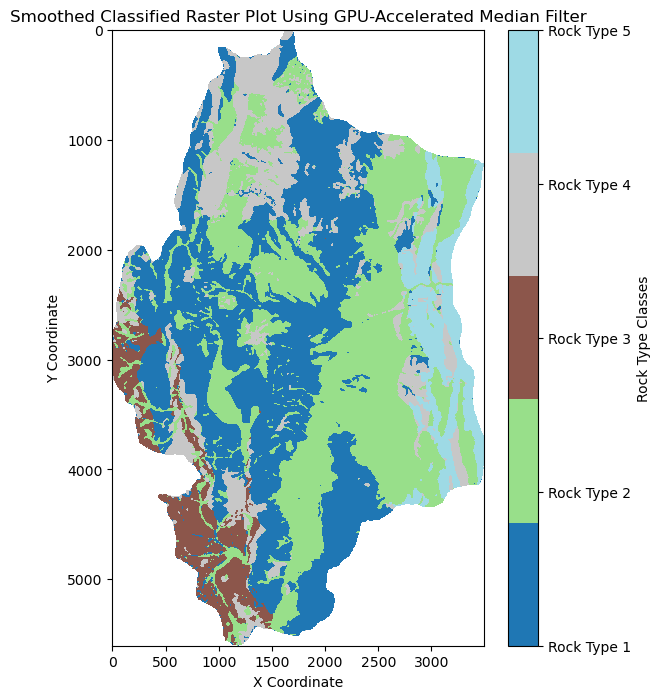

In [80]:
#BETTER PLOT
unique_classes = np.unique(smoothed_data[~np.isnan(smoothed_data)]).astype(int)  # Find unique classes and cast to integers

# Plot the filtered raster array
plt.figure(figsize=(6, 8))

# Get a colormap with the right number of colors
cmap = plt.get_cmap('tab20', len(unique_classes))
plt.imshow(smoothed_data[0], cmap=cmap, interpolation='nearest', aspect='auto')  # Plot the first slice

# Create a colorbar for the classes
cbar = plt.colorbar(label='Rock Type Classes', ticks=unique_classes, format='%d')  # Set ticks to unique classes and format to integers
cbar.set_ticks(unique_classes)  # Explicitly set the ticks to only the unique class values
cbar.set_ticklabels([f'Rock Type {int(cls)}' for cls in unique_classes])  # Label each tick appropriately

plt.title('Smoothed Classified Raster Plot Using GPU-Accelerated Median Filter')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [82]:
#EXPORT GEOSPATIAL DATA

# Write the filtered data back to a new GeoTIFF
output_raster_map = r"C:\Users\TyHow\Documents\3. Work\GIS Stuff\SCP testing\filtered_output.tif"

# Get the shape of the data to be written
height, width = smoothed_data.shape[1], smoothed_data.shape[2]

with rasterio.open(
    output_raster_map,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,  # Number of bands
    dtype='float32',
    crs=crs,
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(smoothed_data[0], 1)  # Write the first band back to the file
